In [114]:
import pandas as pd
import numpy as np
import sklearn.preprocessing as sp
from sklearn.cluster import KMeans
import xgboost as xgb
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### ビーコンに対してスケーリングを行う(本実験では受信機3のデータが取れていない)

In [35]:
# 各受信機データを取得
df1 = pd.read_csv("./取得データセット/受信機1/nkmr1-dataset17.csv")
df2 = pd.read_csv("./取得データセット/受信機2/nkmr2-dataset17.csv")
df4 = pd.read_csv("./取得データセット/受信機4/nkmr4-dataset17.csv")

# それぞれのカラム名の指定
df1.columns = ["UUIDs","Major","Minor","Accuracy","Proximity","TxPower","RSSI","device_name","timestamp","CalRSSI","empty"]
df2.columns = ["UUIDs","Major","Minor","Accuracy","Proximity","TxPower","RSSI","device_name","timestamp","CalRSSI","empty"]
df4.columns = ["UUIDs","Major","Minor","Accuracy","Proximity","TxPower","RSSI","device_name","timestamp","CalRSSI","empty"]

# データの結合
df = df1.append(df2).append(df4)

# 時刻合わせ用ビーコン
set_uuid = "1000000007ae1001b000001c4d8dffff"

# 受信機数を定義
dv_num = len(df["device_name"].unique())

# 使用したビーコンのuuidのリストを設定
uuid_list = [
    "10000000aaaa41441111110000000000",
    "20000000aaaa41441111110000000000",
    "30000000aaaa41441111110000000000",
    "40000000aaaa41441111110000000000",
    "50000000aaaa41441111110000000000",
    "60000000aaaa41441111110000000000",
    "70000000aaaa41441111110000000000",
    "80000000aaaa41441111110000000000",
    "90000000aaaa41441111110000000000",
]

# 地点ごとのデータフレームのリストを作成
df_list = [df[(df.UUIDs == uuid) | (df.UUIDs == set_uuid)] for uuid in uuid_list]

### スケーリング

### 考え方：

サンプルAとBを作成。サンプルAをビーコン1の計測値、サンプルBをビーコン2の計測値と見なす。

In [36]:
A = np.random.randint(10,30,10)
B = np.random.randint(10,30,10)

print("サンプルA:%s" % A)
print("サンプルB:%s" % B)

サンプルA:[29 29 24 13 20 11 17 27 19 15]
サンプルB:[18 15 24 17 24 23 26 19 29 25]


平均と標準偏差

In [37]:
print("A平均値:%s" % A.mean())
print("A標準偏差:%s\n" % A.std())
print("B平均値:%s" % B.mean())
print("B標準偏差:%s" % B.std())

A平均値:20.4
A標準偏差:6.24819974073

B平均値:22.0
B標準偏差:4.26614580154


Aのサンプル値にBの平均値を揃える。

In [38]:
# Aのサンプル値にBの平均値を揃える。
hoge = B - (B.mean() - A.mean())

print("Aのサンプル値にBのサンプル値を揃えたリスト:\n処理後のサンプル値 = %s" % hoge)
print("処理後の平均値:%s" % hoge.mean())
print("処理後の標準偏差:%s" % hoge.std())

Aのサンプル値にBのサンプル値を揃えたリスト:
処理後のサンプル値 = [ 16.4  13.4  22.4  15.4  22.4  21.4  24.4  17.4  27.4  23.4]
処理後の平均値:20.4
処理後の標準偏差:4.26614580154


Aのサンプル値にBの標準偏差の値を揃える。

In [39]:
# Aのサンプル値にBの平均値を揃えた値からAの平均値を引き、平均値からの差を求め、サンプルAとサンプルBの標準偏差の比でスケーリングする
std = ((hoge - A.mean()) * (A.std() / B.std()))
# スケーリングされた標準偏差
print(std)
print()
print("スケーリング後の標準偏差のリスト:%s" % std.std())

[ -5.85840244 -10.25220427   2.92920122  -7.32300305   2.92920122
   1.46460061   5.85840244  -4.39380183  10.25220427   4.39380183]

スケーリング後の標準偏差のリスト:6.24819974073


サンプルAの標準偏差の値と等しく変換できた。後はサンプルBの平均値に上記で求めた標準偏差のリストを加算すれば良い。

In [40]:
# サンプルBの平均値に上記で求めた標準偏差のリストを加算
hoge_list = np.array([hoge.mean() + std for std in std])

print("サンプルA:%s" % A)
print("A平均値:%s" % A.mean())
print("A標準偏差:%s\n" % A.std())
print("サンプルB:%s" % B)
print("B平均値:%s" % B.mean())
print("B標準偏差:%s\n" % B.std())
print("サンプルAの(平均、標準偏差)にサンプルBの(平均、標準偏差)を揃えたリスト:\n %s" % hoge_list)
print("処理後の平均値:%s" % hoge_list.mean())
print("処理後の標準偏差:%s" % hoge_list.std())

サンプルA:[29 29 24 13 20 11 17 27 19 15]
A平均値:20.4
A標準偏差:6.24819974073

サンプルB:[18 15 24 17 24 23 26 19 29 25]
B平均値:22.0
B標準偏差:4.26614580154

サンプルAの(平均、標準偏差)にサンプルBの(平均、標準偏差)を揃えたリスト:
 [ 14.54159756  10.14779573  23.32920122  13.07699695  23.32920122
  21.86460061  26.25840244  16.00619817  30.65220427  24.79380183]
処理後の平均値:20.4
処理後の標準偏差:6.24819974073


In [41]:
# 処理後のリストを表示
print("A: %s" % A)
print("B:%s" % B)
print("処理後のリスト:\n%s" % hoge_list)

A: [29 29 24 13 20 11 17 27 19 15]
B:[18 15 24 17 24 23 26 19 29 25]
処理後のリスト:
[ 14.54159756  10.14779573  23.32920122  13.07699695  23.32920122
  21.86460061  26.25840244  16.00619817  30.65220427  24.79380183]


### スケーリングなしの場合

#### 時刻合わせ

In [42]:
# 前処理用のインスタンスを宣言
le = sp.LabelEncoder()

def set_time(data,set_uuid):
    """
    時刻合わせを行う
    第一引数はdataframe
    第２引数は時刻合わせを行うUUID
    """
    # 時刻合わせ用のビーコンを1秒間隔に設定
    set_time_df = data[data.UUIDs == set_uuid].drop_duplicates(['Minor'],keep = "first")
    # 時刻合わせ用ビーコン以外を定義
    df = data[data.UUIDs != set_uuid]
    # データを結合してインデックスでソート
    df = df.append(set_time_df).sort_index(ascending=True)
    # 時刻合わせ用ビーコンを取得した行にtimeカラムを設定
    df["time"] = df["Minor"].where(df["UUIDs"] == set_uuid)
    # 時刻合わせを行い欠損値がある部分は削除
    df = df.fillna(method="ffill").dropna()
    # int型に変換
    df["time"] = df["time"].astype(int)
    # 時刻合わせ用のビーコンデータ以外
    df = df[df["UUIDs"] != set_uuid]
    
    return df

# 前処理を各データフレームに行う
for (i,df) in enumerate(df_list):
    df_list[i] = set_time(df,set_uuid)
    # device_nameを変換
    df_list[i]["device"] = le.fit_transform(df_list[i][df_list[i].columns[7]]) + 1

#### 入射波と反射波を判別する

In [43]:
def three_d_mc(df_list,column,*,N_CLUSTERS=2):
    """3次元の入力に対するクラスタリングを行う"""
    
    # 空のデータフレームを宣言
    df_cluster = pd.DataFrame()
    return_list = []
    
    for df in df_list: # 入力されたデータフレームの数だけ
        # 空のデータフレームを作成
        hoge = pd.DataFrame()
        for num in range(len(df["device"].unique())): # 受信機の数だけ
            # 受信機ごとにデータフレームを複製
            device_df = df[df["device"] == num+1]
            # クラスタリング
            pred = KMeans(n_clusters=N_CLUSTERS).fit_predict(np.array(device_df[column]))
            # clusterカラムを作成し予測結果を代入
            device_df.loc[:,("cluster")] = pred
            # RSSI値の平均値を比較して入射波と反射波の判定を行う
            if device_df[device_df["cluster"] == 0]["RSSI"].mean() > device_df[device_df["cluster"] == 1]["RSSI"].mean():
                pass
            else:
                device_df[device_df["cluster"] == 0]["cluster"] = 3
                device_df[device_df["cluster"] == 1]["cluster"] = 0
                device_df[device_df["cluster"] == 3]["cluster"] = 1
            
            # データを連結
            hoge = pd.concat([hoge,device_df],ignore_index=True)
        # 予測結果をリストにして返す
        return_list.append(hoge)
    return return_list

In [44]:
df_list = three_d_mc(df_list,["RSSI","device"])

#### 時刻毎に平均値をとり新たにデータフレームを作成

In [45]:
def get_mean(df,colum_name,locate):    
    """
    処理時間かかります。
    時刻毎の中央値をとる
    第一引数、データフレーム
    第２引数、作成したいカラム名
    """
    # 空のデータフレームとリストを用意
    Direct_list = []
    Reflect_list = []
    mid_df = pd.DataFrame()
    
    # timeのユニーク数だけ
    for time_num in range(len(df_list[0]["time"].unique())): 
        # 受信機の数だけ
        for i in range(len(df_list[0]["device"].unique())): 
            # timeラベルが同じ値に対して平均値をとる
            Direct = df[(df["time"] == time_num) & (df["device"] == (i+1)) & (df["cluster"] == 0)]["RSSI"].mean()
            Reflect = df[(df["time"] == time_num) & (df["device"] == (i+1)) & (df["cluster"] == 1)]["RSSI"].mean()
            # 平均値をリストに追加する
            Direct_list.append(Direct)
            Reflect_list.append(Reflect)
        # 平均値を追加したリストに(時間、地点、クラスタ番号を追加)
        Direct_list.extend([time_num,locate,0])
        Reflect_list.extend([time_num,locate,1])
        # データフレームに各要素を追加
        mid_df = mid_df.append(pd.Series(Direct_list),ignore_index=True)
        mid_df = mid_df.append(pd.Series(Reflect_list),ignore_index=True)
        # 平均値のリストを初期化
        Direct_list = []
        Reflect_list = []
    # カラム名を定義
    mid_df.columns = [colum_name]
    
    return mid_df

#前処理を各データフレームと地点毎に行う
train_df = pd.DataFrame()
column_name = ["dev1","dev2","dev4","time","locate","cluster"]
for (locate,df) in enumerate(df_list):
    mid_df = get_mean(df,column_name,(locate+1))
    train_df = pd.concat([train_df,mid_df])

#### 欠損値の除去

In [46]:
direct = train_df[train_df.iloc[:,len(column_name)-1] == 0].dropna(thresh=len(column_name)-1).interpolate().dropna()
reflect = train_df[train_df.iloc[:,len(column_name)-1] == 1].dropna(thresh=len(column_name)-1).interpolate().dropna()
train = pd.concat([direct,reflect])

#### 学習用のデータフレームを作成

In [47]:
train_x = np.array(train[["dev1","dev2","dev4","time","cluster"]])
train_y = np.array(train["locate"])

#### 学習して予測まで

In [48]:
# 検定を行うデータを定義
X = train_x
y = train_y.ravel()
kf = KFold(n_splits=5,shuffle=True)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # オブジェクトを作成し学習
    mod = xgb.XGBClassifier()
    clf = mod.fit(X_train,y_train)
    score = clf.score(X_test,y_test)
    print("精度 : %s" % score)

精度 : 0.946632124352
精度 : 0.937807722208
精度 : 0.951023581239
精度 : 0.942990412024
精度 : 0.943508681005


### スケーリングあり

In [49]:
# 各受信機データを取得
df1 = pd.read_csv("./取得データセット/受信機1/nkmr1-dataset17.csv")
df2 = pd.read_csv("./取得データセット/受信機2/nkmr2-dataset17.csv")
df4 = pd.read_csv("./取得データセット/受信機4/nkmr4-dataset17.csv")

# それぞれのカラム名の指定
df1.columns = ["UUIDs","Major","Minor","Accuracy","Proximity","TxPower","RSSI","device_name","timestamp","xlabel","ylabel"]
df2.columns = ["UUIDs","Major","Minor","Accuracy","Proximity","TxPower","RSSI","device_name","timestamp","xlabel","ylabel"]
df4.columns = ["UUIDs","Major","Minor","Accuracy","Proximity","TxPower","RSSI","device_name","timestamp","xlabel","ylabel"]

# データの結合
df = df1.append(df2).append(df4)

# 時刻合わせ用ビーコン
set_uuid = "1000000007ae1001b000001c4d8dffff"

# 受信機数を定義
dv_num = len(df["device_name"].unique())

# 使用したビーコンのuuidのリストを設定
uuid_list = [
    "10000000aaaa41441111110000000000",
    "20000000aaaa41441111110000000000",
    "30000000aaaa41441111110000000000",
    "40000000aaaa41441111110000000000",
    "50000000aaaa41441111110000000000",
    "60000000aaaa41441111110000000000",
    "70000000aaaa41441111110000000000",
    "80000000aaaa41441111110000000000",
    "90000000aaaa41441111110000000000",
]

# 地点ごとのデータフレームのリストを作成
df_list = [df[(df.UUIDs == uuid) | (df.UUIDs == set_uuid)] for uuid in uuid_list]

#### 時刻合わせを行う

In [50]:
# 前処理を各データフレームに行う
for (i,df) in enumerate(df_list):
    df_list[i] = set_time(df,set_uuid)
    # device_nameを変換
    df_list[i]["device"] = le.fit_transform(df_list[i][df_list[i].columns[7]]) + 1

#### キャリブレーションを行う関数
基本的にはdf_list(発信機ごとに分けられたデータフレーム)の初めの値をオリジナルの値とする。  
df_list[0]以降の値はキャリブレーションされたリストとして返される。

In [51]:
def Calibration(origin,target):
    """
    キャリブレーションを行う関数。
    第1引数にオリジナルとなるnp.arrayをとる。
    第２引数にキャリブレーションを行いたいnp.arrayをとる。
    """
    # ターゲットのリストの平均値にキャリブレーションを行うリストの平均値を揃える
    target = target - (target.mean() - origin.mean())
    # ターゲットリストの平均値からの各値の差を求め、オリジナルとターゲットの標準偏差の比でスケーリング
    std_diff = ((target - origin.mean())*(origin.std() / target.std()))
    # ターゲットリストに計算結果を加算
    result_list = np.array([target.mean() + std_diff for std_diff in std_diff])
    
    return result_list

In [52]:
# 発信機ごとに分けられたデータフレームに対してキャリブレーションを行う
for (i,df) in enumerate(df_list):
    target = np.array(df["RSSI"])
    df_list[i]["CalRSSI"] = Calibration(np.array(df_list[0]["RSSI"]),target)

#### 入射派と反射波を判別する

In [53]:
def three_d_mc(df_list,column,*,N_CLUSTERS=2):
    """3次元の入力に対するクラスタリングを行う"""
    
    # 空のデータフレームを宣言
    df_cluster = pd.DataFrame()
    return_list = []
    
    for df in df_list: # 入力されたデータフレームの数だけ
        # 空のデータフレームを作成
        hoge = pd.DataFrame()
        for num in range(len(df["device"].unique())): # 受信機の数だけ
            # 受信機ごとにデータフレームを複製
            device_df = df[df["device"] == num+1]
            # クラスタリング
            pred = KMeans(n_clusters=N_CLUSTERS).fit_predict(np.array(device_df[column]))
            # clusterカラムを作成し予測結果を代入
            device_df.loc[:,("cluster")] = pred
            # Calib_RSSI値の平均値を比較して入射波と反射波の判定を行う
            if device_df[device_df["cluster"] == 0]["CalRSSI"].mean() > device_df[device_df["cluster"] == 1]["CalRSSI"].mean():
                pass
            else:
                device_df[device_df["cluster"] == 0]["cluster"] = 3
                device_df[device_df["cluster"] == 1]["cluster"] = 0
                device_df[device_df["cluster"] == 3]["cluster"] = 1
            
            # データを連結
            hoge = pd.concat([hoge,device_df],ignore_index=True)
        # 予測結果をリストにして返す
        return_list.append(hoge)
    return return_list

In [54]:
df_list = three_d_mc(df_list,["CalRSSI","device"])

#### 時刻毎に平均値をとり新たにデータフレームを作成

In [55]:
def get_mean(df,colum_name,locate):    
    """
    処理時間かかります。
    時刻毎の中央値をとる
    第一引数、データフレーム
    第２引数、作成したいカラム名
    """
    # 空のデータフレームとリストを用意
    Direct_list = []
    Reflect_list = []
    mid_df = pd.DataFrame()
    
    # timeのユニーク数だけ
    for time_num in range(len(df_list[0]["time"].unique())): 
        # 受信機の数だけ
        for i in range(len(df_list[0]["device"].unique())): 
            # timeラベルが同じ値に対して平均値をとる
            Direct = df[(df["time"] == time_num) & (df["device"] == (i+1)) & (df["cluster"] == 0)]["CalRSSI"].mean()
            Reflect = df[(df["time"] == time_num) & (df["device"] == (i+1)) & (df["cluster"] == 1)]["CalRSSI"].mean()
            # 平均値をリストに追加する
            Direct_list.append(Direct)
            Reflect_list.append(Reflect)
        # 平均値を追加したリストに(時間、地点、クラスタ番号を追加)
        Direct_list.extend([time_num,locate,0])
        Reflect_list.extend([time_num,locate,1])
        # データフレームに各要素を追加
        mid_df = mid_df.append(pd.Series(Direct_list),ignore_index=True)
        mid_df = mid_df.append(pd.Series(Reflect_list),ignore_index=True)
        # 平均値のリストを初期化
        Direct_list = []
        Reflect_list = []
    # カラム名を定義
    mid_df.columns = [colum_name]
    
    return mid_df

#前処理を各データフレームと地点毎に行う
train_df = pd.DataFrame()
column_name = ["dev1","dev2","dev4","time","locate","cluster"]
for (locate,df) in enumerate(df_list):
    mid_df = get_mean(df,column_name,(locate+1))
    train_df = pd.concat([train_df,mid_df])

#### 欠損値の除去

In [56]:
direct = train_df[train_df.iloc[:,len(column_name)-1] == 0].dropna(thresh=len(column_name)-1).interpolate().dropna()
reflect = train_df[train_df.iloc[:,len(column_name)-1] == 1].dropna(thresh=len(column_name)-1).interpolate().dropna()
train = pd.concat([direct,reflect])

#### 学習用のデータフレームの作成

In [57]:
train_x = np.array(train[["dev1","dev2","dev4","time","cluster"]])
train_y = np.array(train["locate"])

#### 学習して予測まで

In [58]:
# 検定を行うデータを定義
X = train_x
y = train_y.ravel()
kf = KFold(n_splits=5,shuffle=True)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # オブジェクトを作成し学習
    mod = xgb.XGBClassifier()
    clf = mod.fit(X_train,y_train)
    score = clf.score(X_test,y_test)
    print("精度 : %s" % score)

精度 : 0.975616083009
精度 : 0.979766536965
精度 : 0.976653696498
精度 : 0.978988326848
精度 : 0.973793461339


スケーリング前：  
精度 : 0.912561258705  
精度 : 0.912045395925  
精度 : 0.909466082022  
精度 : 0.914366778437  
精度 : 0.908176425071  
  
スケーリング後：  
精度 : 0.979523068948  
精度 : 0.980554835364  
精度 : 0.982369717397  
精度 : 0.976406533575  
精度 : 0.982628986259  
  
かなり精度上がった。

### 1m地点の電波情報を使用したキャリブレーション

In [59]:
# キャリブレーションデータを取得
cali_df = pd.read_csv("./取得データセット/受信機2/nkmr2-dataset_cali.csv")
# カラム付け
cali_df.columns = ["UUIDs","Major","Minor","Accuracy","Proximity","TxPower","RSSI","device_name","timestamp","CalRSSI","empty"]
# デバイスごとに列作成
cali_df["device"] = le.fit_transform(cali_df["device_name"]) + 1

#### キャリブレーションのアルゴリズム  
発信機ごとに取得した電波情報を用いてキャリブレーションを行う。  
発信機ごとに1M距離で取得したRSSI値を用いて、発信機ごとの比を計算し差をなくしていく。  
  
1.1M地点で取得したビーコンデータの直接波と減衰波の識別を行う  
2.識別したデータのそれぞれのRSSI値の平均値を求める  
3.それぞれの平均値をUUIDをkeyとした辞書として作成する(直接波と減衰波の違いを辞書でどう表現する？タプルとして持たせるべき？)
  
均一化したデータは新規の列としてデータフレームに持たせて、予測精度の比較を行う  

In [60]:
# 使用したビーコンのuuidのリストを設定
uuid_list = [
    "10000000aaaa41441111110000000000",
    "20000000aaaa41441111110000000000",
    "30000000aaaa41441111110000000000",
    "40000000aaaa41441111110000000000",
    "50000000aaaa41441111110000000000",
    "60000000aaaa41441111110000000000",
    "70000000aaaa41441111110000000000",
    "80000000aaaa41441111110000000000",
    "90000000aaaa41441111110000000000",
]

# 地点ごとのデータフレームのリストを作成
cali_list = [cali_df[cali_df.UUIDs == uuid] for uuid in uuid_list]

##### 1.1M地点で取得したビーコンデータの直接波と減衰波の識別を行う
1M地点で取得したデータセットに対して直接波と減衰波の識別をする。  

In [61]:
cali_list = three_d_mc(cali_list,["RSSI","device"])

##### 2.識別した識別波、反射波のそれぞれのRSSI値の平均を求める
1M地点で取得したクラスタごとの直接波と減衰波の平均値をTxPowerとして設定する。  
求めたTxPowerはUUIDをkeyとした辞書として保管し必要に応じて参照する。  
辞書は(key = UUID、value = tuple(減衰波、直接波))で構成される。  

In [62]:
tp_dict = {}

# UUIDごとのTxPowerの辞書を作成する
for (i,df) in enumerate(cali_list):
    TxPower = []
    for cluster in range(len(df["cluster"].unique())):
        TxPower.append(df[df.cluster == cluster]["RSSI"].mean())
    tp_dict[df.UUIDs[0]] = tuple(sorted(TxPower ))

##### 3.識別したクラスタごとにRSSI値の比を求め、比の値に従って各RSSI値を均一化する
TxPowerを用いてUUIDごとのRSSI値に対して「RSSI/TxPower」の値を計算する。  
ここで、1M地点で取ったビーコンの計測値及び取得した実験データは向きや高さ等に考慮していないことに注意する。  

In [63]:
for (i,uuid) in enumerate(tp_dict):
        for cluster in range(len(tp_dict[uuid])):
            df_list[i]["CalRSSI"][df_list[i]["cluster"] == cluster] = df_list[i][df_list[i]["cluster"] == cluster]["RSSI"] / tp_dict[uuid][cluster]

### キャリブレーション結果を用いて精度の比較を行う
上記で求めたCalRSSI値を学習の際の特徴量として使用した場合に精度にどう影響があるかを確認する。

In [64]:
# 前処理を各データフレームと地点毎に行う
train_df = pd.DataFrame()
column_name = ["dev1","dev2","dev4","time","locate","cluster"]
for (locate,df) in enumerate(df_list):
    mid_df = get_mean(df,column_name,(locate+1))
    train_df = pd.concat([train_df,mid_df])

# 欠損値の除去
direct = train_df[train_df.iloc[:,len(column_name)-1] == 0].dropna(thresh=len(column_name)-1).interpolate().dropna()
reflect = train_df[train_df.iloc[:,len(column_name)-1] == 1].dropna(thresh=len(column_name)-1).interpolate().dropna()
train = pd.concat([direct,reflect])

# 学習用のデータフレームの作成
train_x = np.array(train[["dev1","dev2","dev4","time","cluster"]])
train_y = np.array(train["locate"])

In [65]:
# データを定義
X = train_x
y = train_y.ravel()
kf = KFold(n_splits=5,shuffle=True)

# 学習して予測まで
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # オブジェクトを作成し学習
    mod = xgb.XGBClassifier()
    clf = mod.fit(X_train,y_train)
    score = clf.score(X_test,y_test)
    print("精度 : %s" % score)

精度 : 0.982360570687
精度 : 0.98495460441
精度 : 0.986770428016
精度 : 0.981841763943
精度 : 0.98624805397


キャリブレーションなしの場合と比べて予測精度は上がった。  
次は直接波のみでの予測精度を比較する。  

#### 直接波のみでの学習と予測

In [66]:
def get_mean(df,colum_name,locate):    
    """
    処理時間かかります。
    時刻毎の中央値をとる
    第一引数、データフレーム
    第２引数、作成したいカラム名
    """
    # 空のデータフレームとリストを用意
    Direct_list = []
    Reflect_list = []
    mid_df = pd.DataFrame()
    
    # timeのユニーク数だけ
    for time_num in range(len(df_list[0]["time"].unique())): 
        # 受信機の数だけ
        for i in range(len(df_list[0]["device"].unique())): 
            # timeラベルが同じ値に対して平均値をとる
            Direct = df[(df["time"] == time_num) & (df["device"] == (i+1)) & (df["cluster"] == 0)]["CalRSSI"].mean()
            # 平均値をリストに追加する
            Direct_list.append(Direct)
        # 平均値を追加したリストに(時間、地点、クラスタ番号を追加)
        Direct_list.extend([time_num,locate,0])
        # データフレームに各要素を追加
        mid_df = mid_df.append(pd.Series(Direct_list),ignore_index=True)
        # 平均値のリストを初期化
        Direct_list = []
    # カラム名を定義
    mid_df.columns = [colum_name]
    
    return mid_df

#前処理を各データフレームと地点毎に行う
train_df = pd.DataFrame()
column_name = ["dev1","dev2","dev4","time","locate","cluster"]
for (locate,df) in enumerate(df_list):
    mid_df = get_mean(df,column_name,(locate+1))
    train_df = pd.concat([train_df,mid_df])
    
# 欠損値の除去
direct = train_df[train_df.iloc[:,len(column_name)-1] == 0].dropna(thresh=len(column_name)-1).interpolate().dropna()
reflect = train_df[train_df.iloc[:,len(column_name)-1] == 1].dropna(thresh=len(column_name)-1).interpolate().dropna()
train = pd.concat([direct,reflect])

# 学習用のデータフレームの作成
train_x = np.array(train[["dev1","dev2","dev4","time","cluster"]])
train_y = np.array(train["locate"])

# データを定義
X = train_x
y = train_y.ravel()
kf = KFold(n_splits=5,shuffle=True)

# 学習して予測まで
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # オブジェクトを作成し学習
    mod = xgb.XGBClassifier()
    clf = mod.fit(X_train,y_train)
    score = clf.score(X_test,y_test)
    print("精度 : %s" % score)

精度 : 0.992950654582
精度 : 0.995468277946
精度 : 0.995468277946
精度 : 0.996475327291
精度 : 0.993957703927


キャリブレーション自体は学習に良い影響を与えていることがわかった。  
辞書でTxPowerを持たせてるので元データにも影響がなく今後も学習する際にはキャリブレーションを行なっていきたい。

# 決定木分析を行う 

### データセットと必要ライブラリをインポート

In [169]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
from IPython.display import Image
import pydotplus

# 学習用データを定義(numpyのモジュールであるravelメソッドは多次元配列を1次元配列に変換してくれる。flattenより高速。便利〜。)
train_x = np.array(train[["dev1","dev2","dev4","time","cluster"]])
train_y = np.array(train["locate"]).ravel()

### Decisino Tree

In [ ]:
# 決定木での実装
clf = tree.DecisionTreeClassifier()
mod = clf.fit(train_x,train_y)

dot_data = tree.export_graphviz(
    sub_tree,
    feature_names=["dev1","dev2","dev4","time","cluster"],
    class_names=["1","2","3","4","5","6","7","8","9"],
    out_file=None,filled=True,
    rounded=True,
    special_characters=True,
    proportion=True,
)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

### Gradient Boosting Decision Tree

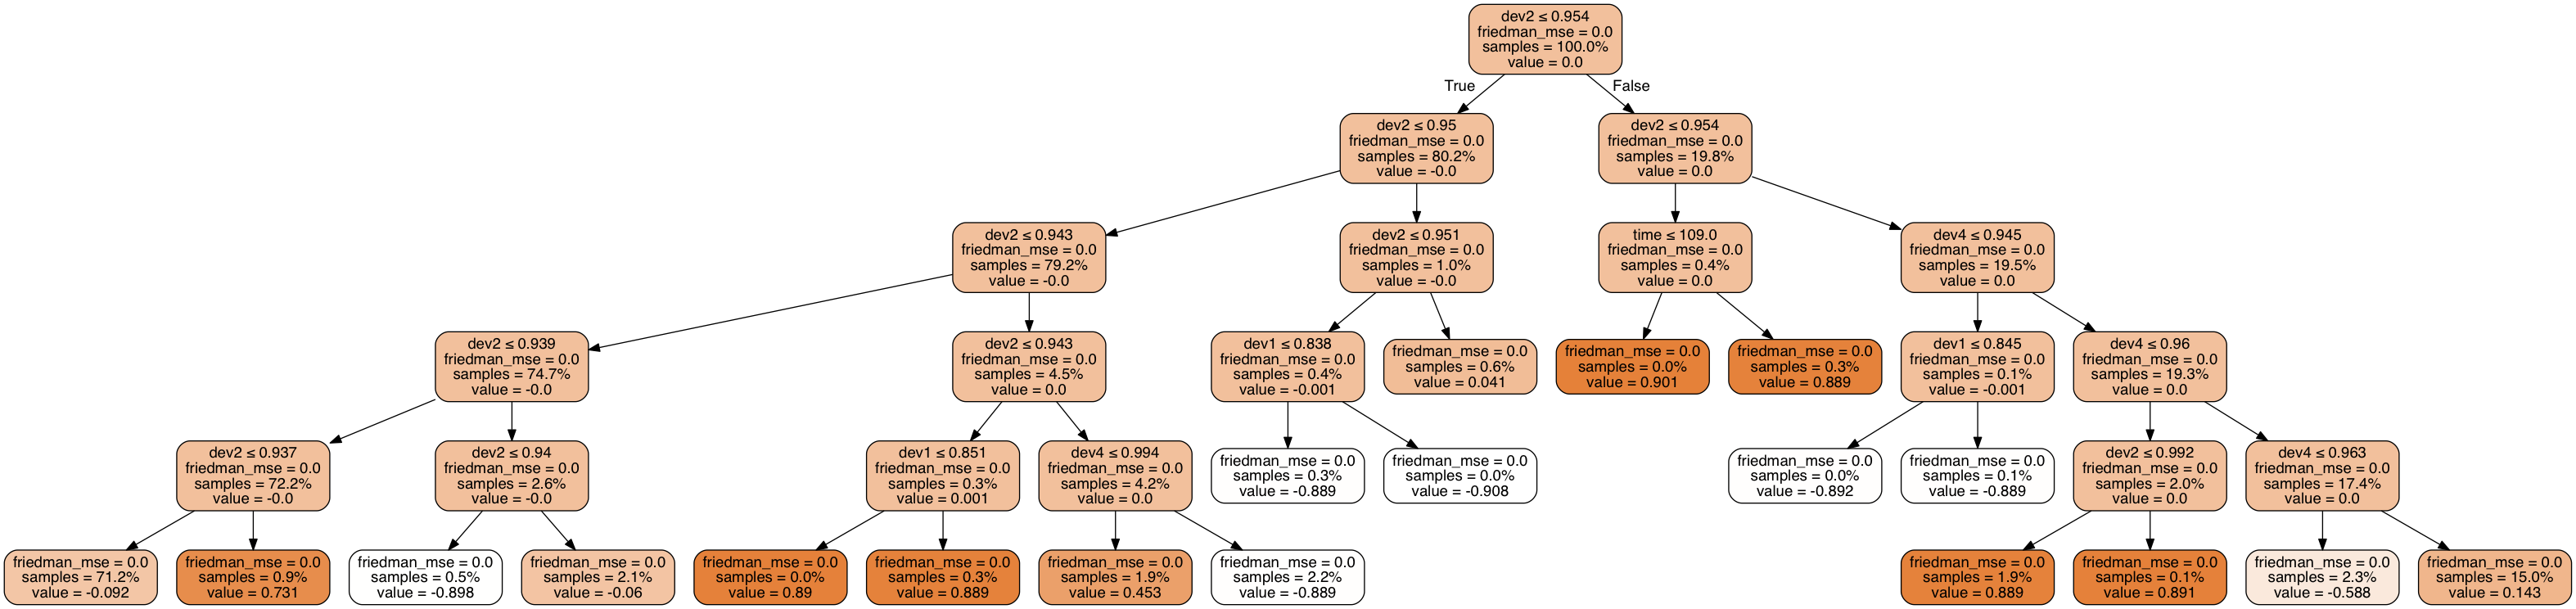

In [167]:
# 学習器を設定
clf = GradientBoostingClassifier(
    n_estimators=200,
    max_depth=5,
    min_samples_leaf=3
)
mod = clf.fit(train_x,train_y)

sub_tree = mod.estimators_[100,0]

dot_data = tree.export_graphviz(
    sub_tree,
    feature_names=["dev1","dev2","dev4","time","cluster"],
    class_names=["1","2","3","4","5","6","7","8","9"],
    out_file=None,filled=True,
    rounded=True,
    special_characters=True,
    proportion=True,
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [161]:
mod.estimators_[190]

array([ DecisionTreeRegressor(criterion='friedman_mse', max_depth=5,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort='auto',
           random_state=<mtrand.RandomState object at 0x109af80d8>,
           splitter='best'),
       DecisionTreeRegressor(criterion='friedman_mse', max_depth=5,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort='auto',
           random_state=<mtrand.RandomState object at 0x109af80d8>,
           splitter='best'),
       DecisionTreeRegressor(criterion='friedman_mse', max_depth=5,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_sample

### モデル(決定木)の可視化を行う

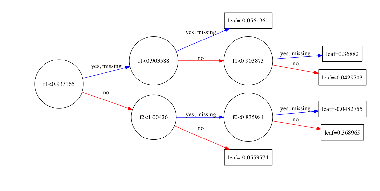

In [116]:
plot_tree(mod,num_trees=0,rankdir="LR")

In [117]:
plt.show()